## Driver code generating brain-maps

### Steps
- import stat csvs 
- visualize quantitative performance  
- visualize brain regions

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import itertools
import pickle
import time
from scipy.spatial import distance
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib

from surfer import Brain
from mayavi import mlab

from tvtk.api import tvtk
from tvtk.common import configure_input_data

mlab.init_notebook()
mlab.options.offscreen = False

# %matplotlib inline

#%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_output/subjects
%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/config

sys.path.append('../')
from lib.plot_utils import *
from lib.data_stats import aggregate_perf

Notebook initialized with x3d backend.
env: SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/config


### Data paths

In [2]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/Amadou/input_CSVs/'
figures_dir = proj_dir + 'data/Amadou/output_figures/'

common_space = proj_dir + 'config/fsaverage/'


brain_coef_file_lh = data_dir + 'out_coef_est_con_lh.csv'
brain_coef_file_rh = data_dir + 'out_coef_est_con_rh.csv'



In [3]:
brain_coef = pd.read_csv(brain_coef_file_lh,index_col=[0])

coef_names = ['asym_mip_coef','asym_him_coef','lasso_coef','mip_coef','him_coef']

print('Shape of df: {}, \ncolumns: {}'.format(brain_coef.shape, coef_names))

brain_coef.head()


Shape of df: (163842, 5), 
columns: ['asym_mip_coef', 'asym_him_coef', 'lasso_coef', 'mip_coef', 'him_coef']


,lasso_coef,asym_him_coef,asym_mip_coef,mip_coef,him_coef
vertex_name,,,,,
vertex1,0.0,0.0,0.0,0.0,0.0
vertex2,0.0,0.0,0.0,0.0,0.0
vertex3,0.0,0.0,0.0,0.0,0.0
vertex4,0.0,0.0,0.0,0.0,0.0
vertex5,0.0,0.0,0.0,0.0,0.0


### Distribution of coefs

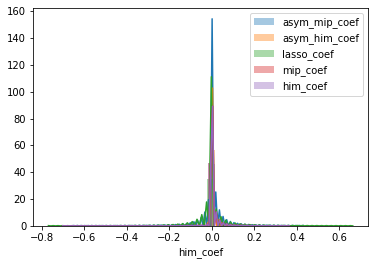

In [4]:
for coef_name in coef_names: 
    sns.distplot(brain_coef[coef_name],label=coef_name)

plt.legend()

## PySurfer plots

In [5]:
def get_nbrs(coords,vertex_idx,n_nbrs=10):
    seeds = coords[vertex_idx]
    dist_array = distance.cdist(seeds, coords, 'euclidean')

    aug_vertex_idx =[]
    for s in range(len(seeds)):
        closest_v = dist_array[s,:].argsort()[:n_nbrs]
        aug_vertex_idx.append(closest_v)

    return np.hstack((aug_vertex_idx))

def plot_vertex_maps(vertex_data, common_space, annot, title, hemi, surf, view, cmap, save_path):

    b = Brain(common_space, hemi, surf, title=title, background="white",views=view)

    # co-ordinates
    x, y, z = b.geo[hemi].coords.T
    tris = b.geo[hemi].faces
    
    coords = np.array([x,y,z]).T
    
    vertex_labels = set(vertex_data) - {0} #exclude background label 
    if view=='medial':
        n_nbrs = 2
    else:
        n_nbrs = 4
        
    print('vertex_labels: {}'.format(vertex_labels))
    for vertex_label in vertex_labels: 
        nbr_indices = get_nbrs(coords,vertex_data==vertex_label,n_nbrs=n_nbrs)
        vertex_data[nbr_indices] = vertex_label
    
    b.add_data(vertex_data, colormap=cmap, alpha=0.95, colorbar=False, center=None) #center=0.0
    
    b.add_annotation("aparc")

    print('Saving surface plot here: {}'.format(save_path))
    b.save_image(save_path)
    
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def get_roi_name(vertex_idx,hemi,aparc_file):
    aparc_file_path = os.path.join(os.environ["SUBJECTS_DIR"],
                                common_space, "label",
                                hemi + aparc_file)
    labels, ctab, names = nib.freesurfer.read_annot(aparc_file_path)
    names = [n.decode("utf-8").replace('-','_') for n in names]
    roi_id = labels[vertex_idx]
    roi_name = names[roi_id]
    roi_member_indices = labels==roi_id
    
    return roi_id, roi_name, roi_member_indices

    

### Get ROI Names

In [134]:
hemi = 'lh'
aparc_file = '.aparc.DKTatlas40.annot' #'.aparc.a2009s.annot' 

for hemi in hemis:
    if hemi == 'lh':
        brain_coef = pd.read_csv(brain_coef_file_lh,index_col=[0])
    elif hemi == 'rh':
        brain_coef = pd.read_csv(brain_coef_file_rh,index_col=[0])
    else:
        print('unknown hemisphere')
        
    print('\nhemisphere: {}'.format(hemi))
    for c, coef_name in enumerate(coef_names):
        print('\n{}'.format(coef_name))
        vertex_data = brain_coef[coef_name].values > 0
        nonzero_vertices = np.hstack(np.nonzero(vertex_data))
        print('Number of nonzero vertices: {}'.format(len(nonzero_vertices)))
        nonzero_rois = []
        for v in nonzero_vertices:
            roi_id, roi_name, roi_member_indices = get_roi_name(v,hemi,aparc_file)
            nonzero_rois.append(roi_name)
            
        nonzero_rois = list(set(nonzero_rois))
        print('nonzero ROIs (n={}):\n{}'.format(len(nonzero_rois),nonzero_rois))


hemisphere: lh

asym_mip_coef
Number of nonzero vertices: 96
nonzero ROIs (n=23):
['lateralorbitofrontal', 'precentral', 'parahippocampal', 'inferiorparietal', 'medialorbitofrontal', 'lateraloccipital', 'superiortemporal', 'parsorbitalis', 'supramarginal', 'postcentral', 'superiorfrontal', 'rostralmiddlefrontal', 'fusiform', 'rostralanteriorcingulate', 'insula', 'unknown', 'caudalanteriorcingulate', 'lingual', 'caudalmiddlefrontal', 'parsopercularis', 'entorhinal', 'superiorparietal', 'middletemporal']

asym_mip_coef
Number of nonzero vertices: 96
nonzero ROIs (n=23):
['lateralorbitofrontal', 'precentral', 'parahippocampal', 'inferiorparietal', 'medialorbitofrontal', 'lateraloccipital', 'superiortemporal', 'parsorbitalis', 'supramarginal', 'postcentral', 'superiorfrontal', 'rostralmiddlefrontal', 'fusiform', 'rostralanteriorcingulate', 'insula', 'unknown', 'caudalanteriorcingulate', 'lingual', 'caudalmiddlefrontal', 'parsopercularis', 'entorhinal', 'superiorparietal', 'middletemporal'

In [9]:
surf = 'inflated' #'white' #"inflated"
subjects_dir = os.environ['SUBJECTS_DIR']
aparc_file = '.aparc.DKTatlas40.annot'

hemis = ['lh','rh']
views = ['lateral','medial']

#cmap = discrete_cmap(10,'YlOrBr') #plt.cmap('hot',10)
my_cmap = ['#ffffff','#e6194b', '#3cb44b','#4363d8', '#f58231', '#911eb4']
# my_cmap = 'Reds'


for hemi in hemis:
    aparc_file_path = os.path.join(os.environ["SUBJECTS_DIR"],
                                common_space, "label",
                                hemi + aparc_file)
    labels, ctab, names = nib.freesurfer.read_annot(aparc_file_path)
    annot = (labels, ctab)
    if hemi == 'lh':
        brain_coef = pd.read_csv(brain_coef_file_lh,index_col=[0])
    elif hemi == 'rh':
        brain_coef = pd.read_csv(brain_coef_file_rh,index_col=[0])
    else:
        print('unknown hemisphere')
      
    vertex_data = np.zeros(brain_coef.shape[0])
    for c, coef_name in enumerate(coef_names):
        vertex_data[brain_coef[coef_name].values != 0] = c+1 #this will overwrite overlapping vertices
        print('{} number of nonzero coef: {}'.format(coef_name,np.sum(brain_coef[coef_name].values != 0)))
              
        print(set(vertex_data))
        #remove coef assigned to medial center area (not part of the atlas)
        vertex_data[labels==0] = 0 
            
    for view in views:
        title = '{}_{}_{}'.format(coef_name,hemi,view)
        save_path = figures_dir + 'coef_binary_{}_{}.png'.format(hemi,view)        
        plot_vertex_maps(vertex_data, common_space, annot, title, hemi, surf, view, my_cmap, save_path)


asym_mip_coef number of nonzero coef: 400
{0.0, 1.0}
asym_him_coef number of nonzero coef: 464
{0.0, 1.0, 2.0}
lasso_coef number of nonzero coef: 428
{0.0, 1.0, 2.0, 3.0}
mip_coef number of nonzero coef: 370
{0.0, 1.0, 2.0, 3.0, 4.0}
him_coef number of nonzero coef: 370
{0.0, 1.0, 2.0, 3.0, 5.0}
vertex_labels: {1.0, 2.0, 3.0, 5.0}
colormap sequential: [0.00e+00, 2.50e+00, 5.00e+00] (opaque)
Saving surface plot here: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/Amadou/output_figures/coef_binary_lh_lateral.png
vertex_labels: {1.0, 2.0, 3.0, 5.0}
colormap sequential: [0.00e+00, 2.50e+00, 5.00e+00] (opaque)
Saving surface plot here: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/Amadou/output_figures/coef_binary_lh_medial.png
asym_mip_coef number of nonzero coef: 774
{0.0, 1.0}
asym_him_coef number of nonzero coef: 642
{0.0, 1.0, 2.0}
lasso_coef number of nonzero coef: 536
{0.0, 1.0, 2.0, 3.0}
mip_coef number of nonzero coef: 515
{0.0, 1.0, 2.0, 3.0, 4.0

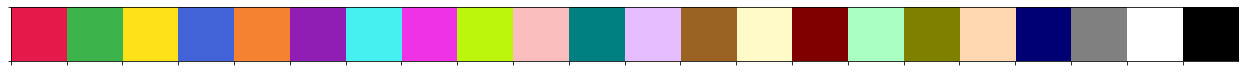

In [35]:
#https://colorbrewer2.org/#type=sequential&scheme=Greys&n=8

sns.palplot(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', 
             '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
             '#800000', '#aaffc3', '#808000', '#ffd8b1', 
             '#000075', '#808080', '#ffffff', '#000000'])

<Figure size 1080x360 with 0 Axes>

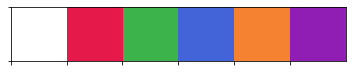

In [49]:
plt.figure(figsize=(15,5))
sns.palplot(my_cmap)

In [6]:
asym_mip_coef = set(np.hstack(np.nonzero(brain_coef['asym_mip_coef'].values)))
asym_him_coef = set(np.hstack(np.nonzero(brain_coef['asym_him_coef'].values)))
lasso_coef = set(np.hstack(np.nonzero(brain_coef['lasso_coef'].values)))
mip_coef = set(np.hstack(np.nonzero(brain_coef['mip_coef'].values)))
him_coef = set(np.hstack(np.nonzero(brain_coef['him_coef'].values)))

len(asym_mip_coef),len(asym_him_coef),len(lasso_coef),len(mip_coef),len(him_coef)

(400, 464, 428, 370, 370)

In [7]:
brain_coef[brain_coef['mip_coef']!=0]

,lasso_coef,asym_him_coef,asym_mip_coef,mip_coef,him_coef
vertex_name,,,,,
vertex52,0.000000,-0.015982,0.000000,-0.066743,-0.066743
vertex334,0.000000,0.000000,0.000000,0.094691,0.094691
vertex739,0.000000,0.000000,0.000000,-0.058765,-0.058765
vertex863,0.000000,0.000000,0.000000,0.148592,0.148592
vertex885,0.000000,0.000000,0.000000,-0.089754,-0.089754
vertex1644,0.000000,0.000000,0.000000,-0.163978,-0.163978
vertex3090,0.000000,0.000000,0.000000,0.026693,0.026693
vertex3323,0.000000,0.000000,0.000000,-0.165723,-0.165723
vertex3408,0.000000,0.000000,0.000000,-0.077756,-0.077756
